# Model transport logistikasi uchun muqobil narx predict qiladi

In [144]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,root_mean_squared_error,r2_score
from tabulate import tabulate
import joblib
import plotly.express as px
from sklearn.linear_model import Ridge,Lasso
from sklearn.svm import SVC
from sklearn.model_selection import KFold,cross_val_score,train_test_split
import matplotlib.pyplot as plt


In [66]:
df=pd.read_csv('Delivery_Logistics.csv')

# Data bilan tanishuv

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   delivery_id          25000 non-null  float64
 1   delivery_partner     25000 non-null  object 
 2   package_type         25000 non-null  object 
 3   vehicle_type         25000 non-null  object 
 4   delivery_mode        25000 non-null  object 
 5   region               25000 non-null  object 
 6   weather_condition    25000 non-null  object 
 7   distance_km          25000 non-null  float64
 8   package_weight_kg    25000 non-null  float64
 9   delivery_time_hours  25000 non-null  object 
 10  expected_time_hours  25000 non-null  object 
 11  delayed              25000 non-null  object 
 12  delivery_status      25000 non-null  object 
 13  delivery_rating      25000 non-null  int64  
 14  delivery_cost        25000 non-null  float64
dtypes: float64(4), int64(1), object(10)


In [68]:
#delivery id=yuk idsi
#delivery partner=yuk tashuvhi
#package type=yuk turi
#vehicle type=transport vositasi
#delivery mode=yetkazish vaqti
#region=yetkazish manzili
#wheather condition=ob havo
#distance km=masofa
#package weight kg =vazni
#delivery time hours=qancha vaqt ketishi
#expected time=kutilgan vaqt 
#delayed=kechiktirilgani haqida malumot
#delivery_status=yetkazilgani haqida malumot
#delivery rating= xizmat sifati
#delivery_cost=narxi

In [69]:
df.head()

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delivery_time_hours,expected_time_hours,delayed,delivery_status,delivery_rating,delivery_cost
0,250.99,delhivery,automobile parts,bike,same day,west,clear,297.0,46.96,1970-01-01 00:00:00.000000008,1970-01-01 00:00:00.000000008,no,delivered,3,1632.7206
1,250.99,xpressbees,cosmetics,ev van,express,central,cold,89.6,47.39,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000003,no,delivered,5,640.1700
2,250.99,shadowfax,groceries,truck,two day,east,rainy,273.5,26.89,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000016,no,delivered,4,1448.1700
3,250.99,dhl,electronics,ev van,same day,east,cold,269.7,12.69,1970-01-01 00:00:00.000000006,1970-01-01 00:00:00.000000008,no,delivered,3,1486.5700
4,250.99,dhl,clothing,van,two day,north,foggy,256.7,37.02,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000000016,no,delivered,4,1394.5600


In [70]:
import os
folder="Data"
filename="df_row.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

# Preprocessing


In [71]:
def clean(df):
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype=='object':
                df[col].fillna(df[col].mode()[0],inplace=True)
            else:
                df[col].fillna(df[col].mean(),inplace=True)
    return df

In [72]:
clean(df)

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delivery_time_hours,expected_time_hours,delayed,delivery_status,delivery_rating,delivery_cost
0,250.99,delhivery,automobile parts,bike,same day,west,clear,297.0,46.96,1970-01-01 00:00:00.000000008,1970-01-01 00:00:00.000000008,no,delivered,3,1632.7206
1,250.99,xpressbees,cosmetics,ev van,express,central,cold,89.6,47.39,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000003,no,delivered,5,640.1700
2,250.99,shadowfax,groceries,truck,two day,east,rainy,273.5,26.89,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000016,no,delivered,4,1448.1700
3,250.99,dhl,electronics,ev van,same day,east,cold,269.7,12.69,1970-01-01 00:00:00.000000006,1970-01-01 00:00:00.000000008,no,delivered,3,1486.5700
4,250.99,dhl,clothing,van,two day,north,foggy,256.7,37.02,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000000016,no,delivered,4,1394.5600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24750.01,dhl,furniture,scooter,two day,east,foggy,80.7,3.65,1970-01-01 00:00:00.000000004,1970-01-01 00:00:00.000000016,no,delivered,5,414.4500
24996,24750.01,ecom express,automobile parts,ev van,standard,west,clear,172.9,21.42,1970-01-01 00:00:00.000000005,1970-01-01 00:00:00.000000024,no,delivered,5,928.7600
24997,24750.01,ekart,clothing,scooter,same day,east,rainy,168.4,4.85,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000000008,yes,delayed,2,956.5500
24998,24750.01,shadowfax,documents,ev van,standard,west,stormy,37.2,8.04,1970-01-01 00:00:00.000000006,1970-01-01 00:00:00.000000024,no,delivered,5,210.1200


In [73]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=encoder.fit_transform(df[col])

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   delivery_id          25000 non-null  float64
 1   delivery_partner     25000 non-null  int64  
 2   package_type         25000 non-null  int64  
 3   vehicle_type         25000 non-null  int64  
 4   delivery_mode        25000 non-null  int64  
 5   region               25000 non-null  int64  
 6   weather_condition    25000 non-null  int64  
 7   distance_km          25000 non-null  float64
 8   package_weight_kg    25000 non-null  float64
 9   delivery_time_hours  25000 non-null  int64  
 10  expected_time_hours  25000 non-null  int64  
 11  delayed              25000 non-null  int64  
 12  delivery_status      25000 non-null  int64  
 13  delivery_rating      25000 non-null  int64  
 14  delivery_cost        25000 non-null  float64
dtypes: float64(4), int64(11)
memory usag

# heat map

In [75]:
input_features=df.drop('delivery_cost',axis=1)
import plotly.express as px


In [76]:
corr_matrix=input_features.corr()
fig=px.imshow(corr_matrix,text_auto=True,color_continuous_scale='RdBu_r',zmin=1,zmax=1)
fig.show()

In [77]:
target = "delivery_cost"   

corr_to_target = df.corr()[target]   

selected_features = corr_to_target[corr_to_target > 0.005].index.tolist()

print(selected_features)

['distance_km', 'package_weight_kg', 'delivery_time_hours', 'expected_time_hours', 'delayed', 'delivery_cost']


In [78]:
corr=input_features.corr()

In [79]:
corr

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delivery_time_hours,expected_time_hours,delayed,delivery_status,delivery_rating
delivery_id,1.000000,0.002056,0.005146,-0.006522,-0.002225,-0.000686,0.003050,-0.004240,-0.008811,-0.003344,0.000270,-0.000541,-0.003879,0.003587
delivery_partner,0.002056,1.000000,0.007256,-0.001336,-0.008204,0.000014,-0.000278,0.002855,-0.002070,0.001350,-0.007342,0.006980,-0.010766,-0.007637
package_type,0.005146,0.007256,1.000000,0.001709,-0.003480,-0.005403,-0.002341,-0.008426,0.003309,-0.005402,-0.004511,0.004300,-0.011004,-0.005722
vehicle_type,-0.006522,-0.001336,0.001709,1.000000,0.001945,0.008528,0.003051,-0.009112,0.004624,0.000683,0.008219,-0.000002,0.001974,0.002842
delivery_mode,-0.002225,-0.008204,-0.003480,0.001945,1.000000,-0.007424,0.007812,-0.003815,-0.003615,0.004863,0.772254,-0.637929,0.348166,0.493199
region,-0.000686,0.000014,-0.005403,0.008528,-0.007424,1.000000,0.001800,0.002911,-0.011396,0.000450,-0.005545,0.001136,0.001751,-0.006809
weather_condition,0.003050,-0.000278,-0.002341,0.003051,0.007812,0.001800,1.000000,-0.002497,0.008341,0.428604,0.004511,0.188728,-0.093029,-0.142722
distance_km,-0.004240,0.002855,-0.008426,-0.009112,-0.003815,0.002911,-0.002497,1.000000,0.002311,0.685883,0.181449,0.174365,-0.105126,-0.132634
package_weight_kg,-0.008811,-0.002070,0.003309,0.004624,-0.003615,-0.011396,0.008341,0.002311,1.000000,0.001242,-0.001466,0.000962,-0.002011,-0.002891
delivery_time_hours,-0.003344,0.001350,-0.005402,0.000683,0.004863,0.000450,0.428604,0.685883,0.001242,1.000000,0.132254,0.357752,-0.195672,-0.272637


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   delivery_id          25000 non-null  float64
 1   delivery_partner     25000 non-null  int64  
 2   package_type         25000 non-null  int64  
 3   vehicle_type         25000 non-null  int64  
 4   delivery_mode        25000 non-null  int64  
 5   region               25000 non-null  int64  
 6   weather_condition    25000 non-null  int64  
 7   distance_km          25000 non-null  float64
 8   package_weight_kg    25000 non-null  float64
 9   delivery_time_hours  25000 non-null  int64  
 10  expected_time_hours  25000 non-null  int64  
 11  delayed              25000 non-null  int64  
 12  delivery_status      25000 non-null  int64  
 13  delivery_rating      25000 non-null  int64  
 14  delivery_cost        25000 non-null  float64
dtypes: float64(4), int64(11)
memory usag

In [81]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['delivery_mode']=encoder.fit_transform(df['delivery_mode'])

In [82]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['region']=encoder.fit_transform(df['region'])

In [83]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['weather_condition']=encoder.fit_transform(df['weather_condition'])

In [84]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['delivery_time_hours']=encoder.fit_transform(df['delivery_time_hours'])

In [85]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['expected_time_hours']=encoder.fit_transform(df['expected_time_hours'])

In [86]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['delayed']=encoder.fit_transform(df['delayed'])

In [87]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['delivery_status']=encoder.fit_transform(df['delivery_status'])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   delivery_id          25000 non-null  float64
 1   delivery_partner     25000 non-null  int64  
 2   package_type         25000 non-null  int64  
 3   vehicle_type         25000 non-null  int64  
 4   delivery_mode        25000 non-null  int64  
 5   region               25000 non-null  int64  
 6   weather_condition    25000 non-null  int64  
 7   distance_km          25000 non-null  float64
 8   package_weight_kg    25000 non-null  float64
 9   delivery_time_hours  25000 non-null  int64  
 10  expected_time_hours  25000 non-null  int64  
 11  delayed              25000 non-null  int64  
 12  delivery_status      25000 non-null  int64  
 13  delivery_rating      25000 non-null  int64  
 14  delivery_cost        25000 non-null  float64
dtypes: float64(4), int64(11)
memory usag

In [89]:
scaler=MinMaxScaler()
def scale(df):
    num_col=df.select_dtypes(include=['float64']).columns.drop('delivery_cost')
    df[num_col]=scaler.fit_transform(df[num_col])
    return df

In [90]:
scale(df)

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delivery_time_hours,expected_time_hours,delayed,delivery_status,delivery_rating,delivery_cost
0,0.0,2,0,0,1,4,0,0.999659,0.947595,8,6,0,1,3,1632.7206
1,0.0,8,2,2,0,0,1,0.293015,0.956397,2,1,0,1,5,640.1700
2,0.0,7,7,4,3,1,4,0.919591,0.536745,10,7,0,1,4,1448.1700
3,0.0,3,4,2,1,1,1,0.906644,0.246059,6,6,0,1,3,1486.5700
4,0.0,3,1,5,3,2,2,0.862351,0.744115,9,7,0,1,4,1394.5600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.0,3,6,3,3,1,2,0.262692,0.061003,4,7,0,1,5,414.4500
24996,1.0,4,0,2,2,4,0,0.576831,0.424770,5,8,0,1,5,928.7600
24997,1.0,5,1,3,1,1,4,0.561499,0.085568,9,6,1,0,2,956.5500
24998,1.0,7,3,2,2,4,5,0.114480,0.150870,6,8,0,1,5,210.1200


In [91]:
import os
folder="Data"
filename="df_preprocessed.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

# Feature creation

In [92]:
df['difference_hours_delivering']=df['delivery_time_hours']-df['expected_time_hours']

# Feature transforming

In [93]:
from scipy.stats import boxcox
from scipy.stats import yeojohnson

In [94]:
import plotly.express as px

In [95]:
import numpy as np
numeric_cols=df.select_dtypes(include=np.number).columns
skew_values=df[numeric_cols].skew().reset_index()
skew_values.columns=['feature','skewness']
print('skewness table:')
print(skew_values)

skewness table:
                        feature      skewness
0                   delivery_id  4.455629e-16
1              delivery_partner -1.837273e-03
2                  package_type  3.068872e-03
3                  vehicle_type  2.375976e-03
4                 delivery_mode  2.003153e-04
5                        region -6.098948e-03
6             weather_condition -1.685253e-03
7                   distance_km  1.882955e-03
8             package_weight_kg -2.606811e-03
9           delivery_time_hours  4.128956e-01
10          expected_time_hours -1.267568e+00
11                      delayed  1.054813e+00
12              delivery_status -3.409255e-01
13              delivery_rating -4.731261e-01
14                delivery_cost  1.107873e-03
15  difference_hours_delivering  1.607397e-01


In [96]:
threshold=0.00

In [97]:
threshold >=0.5
skewed_cols = skew_values[skew_values['skewness'].abs() > threshold]['feature'].tolist()

In [98]:
skewed_cols

['delivery_id',
 'delivery_partner',
 'package_type',
 'vehicle_type',
 'delivery_mode',
 'region',
 'weather_condition',
 'distance_km',
 'package_weight_kg',
 'delivery_time_hours',
 'expected_time_hours',
 'delayed',
 'delivery_status',
 'delivery_rating',
 'delivery_cost',
 'difference_hours_delivering']

In [99]:
for col in skewed_cols:
    if (df[col] > 0).all():
        if skew_values[skew_values['feature'] == col]['skewness'].values[0] > 1.5:
            df[col], _ = boxcox(df[col])
        else:
            df[col] = np.log1p(df[col])
    else:
        df[col], _ = yeojohnson(df[col])

In [100]:
skew_values_after = df[numeric_cols].skew().reset_index()
skew_values_after.columns = ['feature', 'skewness']

In [101]:
skew_values_after.columns

Index(['feature', 'skewness'], dtype='object')

# Feature selection

In [102]:
input_features=df.drop('delivery_cost',axis=1)
import plotly.express as px

In [103]:
corr_matrix=input_features.corr()
fig=px.imshow(corr_matrix,text_auto=True,color_continuous_scale='RdBu_r',zmin=1,zmax=1)
fig.show()

In [104]:
target = "delivery_cost"   

corr_to_target = df.corr()[target]   

selected_features = corr_to_target[corr_to_target > 0.005].index.tolist()

print(selected_features)

['distance_km', 'package_weight_kg', 'delivery_time_hours', 'expected_time_hours', 'delayed', 'delivery_cost', 'difference_hours_delivering']


In [105]:
corr=input_features.corr()

In [106]:
corr

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delivery_time_hours,expected_time_hours,delayed,delivery_status,delivery_rating,difference_hours_delivering
delivery_id,1.000000,0.001943,0.006251,-0.006700,-0.001619,-0.001026,0.002765,-0.004587,-0.009273,-0.003702,0.002555,-0.000438,-0.004072,0.002495,-0.002852
delivery_partner,0.001943,1.000000,0.007031,-0.002120,-0.007795,0.000163,-0.000580,0.002592,-0.001987,0.000134,-0.005575,0.005987,-0.010417,-0.005402,0.004876
package_type,0.006251,0.007031,1.000000,0.002158,-0.003606,-0.004883,-0.001414,-0.009686,0.003509,-0.006823,-0.001895,0.004364,-0.011430,-0.004933,-0.002362
vehicle_type,-0.006700,-0.002120,0.002158,1.000000,0.003089,0.008061,0.002720,-0.008791,0.004365,0.000654,0.008522,-0.000360,0.001817,0.003053,-0.005152
delivery_mode,-0.001619,-0.007795,-0.003606,0.003089,1.000000,-0.006831,0.007693,-0.004081,-0.003698,0.005372,0.827269,-0.651638,0.314676,0.514652,-0.491023
region,-0.001026,0.000163,-0.004883,0.008061,-0.006831,1.000000,0.002023,0.002176,-0.012190,0.000533,-0.003251,0.000554,0.001476,-0.005170,0.003286
weather_condition,0.002765,-0.000580,-0.001414,0.002720,0.007693,0.002023,1.000000,-0.002146,0.008660,0.415482,0.006352,0.184877,-0.079100,-0.144579,0.359181
distance_km,-0.004587,0.002592,-0.009686,-0.008791,-0.004081,0.002176,-0.002146,1.000000,0.002544,0.696610,0.100231,0.173824,-0.093993,-0.134343,0.491970
package_weight_kg,-0.009273,-0.001987,0.003509,0.004365,-0.003698,-0.012190,0.008660,0.002544,1.000000,0.000398,-0.001175,0.000818,-0.001993,-0.002558,0.001700
delivery_time_hours,-0.003702,0.000134,-0.006823,0.000654,0.005372,0.000533,0.415482,0.696610,0.000398,1.000000,0.078339,0.355268,-0.171016,-0.277882,0.784332


In [107]:
import os
folder="Data"
filename="df_engeenered.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

# visualisation

In [138]:
x=df['delivery_rating']
y=df['delivery_status']

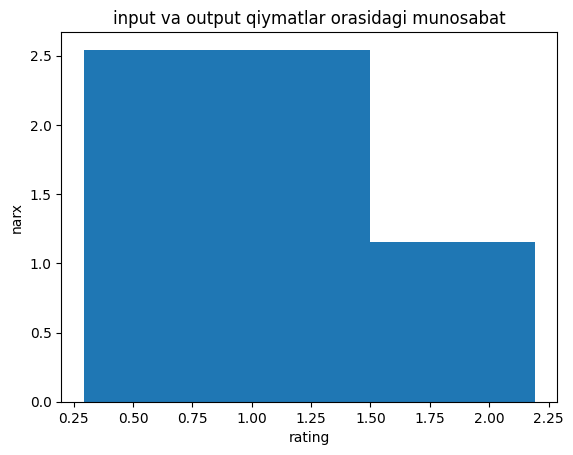

In [145]:
plt.bar(x,y)
plt.title('input va output qiymatlar orasidagi munosabat')
plt.xlabel('rating')
plt.ylabel('narx')
plt.show()

In [149]:
fig=px.line(df,x=df['distance_km'],y=df['delivery_cost'],title='masofaga nisbatan narx')
fig.show()

In [150]:
fig=px.line(df,x=df['weather_condition'],y=df['difference_hours_delivering'],title='ob havoga nisbatan')
fig.show()

In [152]:
fig=px.line(df,x=df['delivery_cost'],y=df['delivery_time_hours'],title="xello")
fig.show()

# Training

In [108]:
x=df.drop('delivery_cost',axis=1)
y=df['delivery_cost']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [137]:
import os
folder="Data"
filename="df_trained.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

In [ ]:
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
lr=LinearRegression()
rd=Ridge(alpha=10.0)
ls=Lasso(alpha=0.01)

In [118]:
dt.fit(x_train,y_train)
y_pred=dt.predict(x_test)
r2=r2_score(y_test,y_pred)
error=root_mean_squared_error(y_test,y_pred)
print(r2)
print(error)

0.9992860973574518
0.01777549357892105


In [117]:
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
r2=r2_score(y_test,y_pred)
error=root_mean_squared_error(y_test,y_pred)
print(r2)
print(error)


0.9998213092618891
0.008893100400631009


In [120]:
rd.fit(x_train,y_train)
y_pred=rd.predict(x_test)
r2=r2_score(y_test,y_pred)
error=root_mean_squared_error(y_test,y_pred)
print(r2)
print(error)

0.9162377350104908
0.19254239971288054


In [121]:
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)
r2=r2_score(y_test,y_pred)
error=root_mean_squared_error(y_test,y_pred)
print(r2)
print(error)

0.916392875854491
0.1923640077200383


In [122]:
ls.fit(x_train,y_train)
y_pred=ls.predict(x_test)
r2=r2_score(y_test,y_pred)
error=root_mean_squared_error(y_test,y_pred)
print(r2)
print(error)

0.900979755712383
0.20934576069297597


In [134]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
scores=cross_val_score(dt,x,y,cv=kf)
scores.mean()

np.float64(0.9994047115165575)

In [ ]:
results=[
["not engeenered",0.99,8.48],
["engeneered",0.99,0.17],
]
print(tabulate(results,headers=[' algorithm','score','error'],tablefmt='grid'))

+----------------+---------+---------+
|  algorithm     |   score |   error |
+================+=========+=========+
| not engeenered |    0.99 |    8.48 |
+----------------+---------+---------+
| engeneered     |    0.99 |    0.17 |
+----------------+---------+---------+


In [135]:
results=[
["Desicion Tree",0.999,0.017],
["Random Forest",0.999,0.008],
["Linear Regression",0.916,0.192],
["Lasso Regression",0.900,0.209],
["Ridge Regression",0.916,0.192],
["KFold",0.999]
]
print(tabulate(results,headers=[' algorithm','score','error'],tablefmt='grid'))

+-------------------+---------+---------+
|  algorithm        |   score |   error |
+===================+=========+=========+
| Desicion Tree     |   0.999 |   0.017 |
+-------------------+---------+---------+
| Random Forest     |   0.999 |   0.008 |
+-------------------+---------+---------+
| Linear Regression |   0.916 |   0.192 |
+-------------------+---------+---------+
| Lasso Regression  |   0.9   |   0.209 |
+-------------------+---------+---------+
| Ridge Regression  |   0.916 |   0.192 |
+-------------------+---------+---------+
| KFold             |   0.999 |         |
+-------------------+---------+---------+


In [136]:
results=[
["Random Forest",0.999,0.008],
]
print(tabulate(results,headers=[' best algorithm','score','error'],tablefmt='grid'))

+-------------------+---------+---------+
|  best algorithm   |   score |   error |
+===================+=========+=========+
| Random Forest     |   0.999 |   0.008 |
+-------------------+---------+---------+
